# Trabajo Integrador Individual - NLP
## "De Texto Crudo a Insights: Pipeline Completo de Análisis de NLP"

El análisis del corpus seleccionado girará en torno a la siguiente pregunta que explica la eleccion del mismo:
**"¿Cómo difiere el lenguaje, los temas y el tono en los cuentos de Horacio Quiroga cuando escribe para un público adulto (explorando la muerte, la locura y la crudeza de la naturaleza) frente a cuando escribe fábulas para un público infantil?"**

**Hipótesis**: Esperamos encontrar un vocabulario significativamente más oscuro, violento y complejo en los cuentos para adultos, mientras que las fábulas utilizarán un lenguaje más simple, centrado en animales y con una connotación más positiva o moralizante.

Fuente del corpus: https://ciudadseva.com/autor/horacio-quiroga/cuentos/




##1. Preparación del Entorno incluida la carga y y organización de datos

In [120]:
# Importación de librerías necesarias
import pandas as pd
import os
import numpy as np
import pickle
import re
import string
from collections import Counter
from nltk.corpus import stopwords


# Librerías de NLP
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Librerías de visualización
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Configuración para Google Colab
from google.colab import drive

# Configuración de pandas para mostrar más contenido en las celdas
pd.set_option('max_colwidth', 150)

print("Todas las librerías importadas correctamente")

print("Todo listo para empezar.")

Todas las librerías importadas correctamente
Todo listo para empezar.


### Conexión con Google Drive y carga y exploración de datos

### Estructura del Corpus

Nuestro corpus consiste en 18 archivos correspondientes a cuentos seleccionados de Horacio Quiroga publicados entre 1909 y 1928. Cada archivo contiene un cuento específico, ya sea de su producción para adultos o de sus fábulas infantiles.

**Formato de archivos:**
- Archivos `.txt`
- Un archivo por cuento: `01_el_almohadon_de_plumas.txt`, ..., `18_el_paso_del_yabebiri`
- Cada archivo contiene un único string con el texto completo del cuento correspondiente.

In [121]:
drive.mount('/content/drive')

# 1 Definir la ruta donde están almacenados los cuentos
path_base = '/content/drive/MyDrive/PLN/jimenez-stefania-nlp-integrador/corpus/'

directorio_textos = os.path.join(path_base, 'raw_texts')
archivo_metadata = os.path.join(path_base, 'metadata.csv')

print(f"Cargando metadatos desde: {archivo_metadata}")

# 2. Cargamos nuestro archivo de metadatos
df_corpus = pd.read_csv(archivo_metadata)

# 3. Leemos cada archivo de texto basándonos en la información de los metadatos
textos_completos = []
for nombre_archivo in df_corpus['archivo']:
    ruta_archivo = os.path.join(directorio_textos, nombre_archivo)
    with open(ruta_archivo, 'r', encoding='utf-8') as f:
        textos_completos.append(f.read())

# 4. Añadimos los textos al DataFrame para tener todo en un solo lugar
df_corpus['texto_completo'] = textos_completos

# --- Verificación ---
print("\n¡Corpus cargado con éxito desde Google Drive!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cargando metadatos desde: /content/drive/MyDrive/PLN/jimenez-stefania-nlp-integrador/corpus/metadata.csv

¡Corpus cargado con éxito desde Google Drive!


### Exploración Inicial del Corpus

In [122]:
print("Iniciando la exploración del corpus...")
print("-" * 50)

# --- A. Estadísticas para cada cuento individual ---
print("ESTADÍSTICAS POR CADA CUENTO INDIVIDUAL:")

# 1. Calculamos el número de caracteres y palabras para cada cuento
df_corpus['num_caracteres'] = df_corpus['texto_completo'].apply(len)
df_corpus['num_palabras_aprox'] = df_corpus['texto_completo'].apply(lambda x: len(x.split()))

# 2. Mostramos la información para cada archivo
for index, row in df_corpus.iterrows():
    # Usamos :<35 para alinear los títulos y que se vea más ordenado
    titulo_ajustado = f"'{row['titulo']}'"[:35].ljust(35)
    print(f"✓ {titulo_ajustado}: {row['num_caracteres']:,} caracteres, ~{row['num_palabras_aprox']:,} palabras")

print("-" * 50)


# --- C. Estadísticas totales del corpus ---
total_cuentos = len(df_corpus)
total_caracteres_corpus = df_corpus['num_caracteres'].sum()
total_palabras_corpus = df_corpus['num_palabras_aprox'].sum()

print("\nRESUMEN TOTAL DEL CORPUS:")
print(f"- Número total de cuentos: {total_cuentos}")
print(f"- Número total de caracteres: {total_caracteres_corpus:,}")
print(f"- Número total de palabras (aprox.): {total_palabras_corpus:,}")

Iniciando la exploración del corpus...
--------------------------------------------------
ESTADÍSTICAS POR CADA CUENTO INDIVIDUAL:
✓ 'El almohadón de plumas'           : 7,202 caracteres, ~1,215 palabras
✓ 'La gallina degollada'             : 14,112 caracteres, ~2,389 palabras
✓ 'A la deriva'                      : 6,113 caracteres, ~1,057 palabras
✓ 'El hombre muerto'                 : 8,119 caracteres, ~1,440 palabras
✓ 'El hijo'                          : 9,207 caracteres, ~1,703 palabras
✓ 'La insolación'                    : 13,609 caracteres, ~2,348 palabras
✓ 'Los mensú'                        : 20,095 caracteres, ~3,391 palabras
✓ 'El solitario'                     : 8,830 caracteres, ~1,504 palabras
✓ 'La miel silvestre'                : 10,084 caracteres, ~1,716 palabras
✓ 'El vampiro'                       : 5,149 caracteres, ~899 palabras
✓ 'La tortuga gigante'               : 9,080 caracteres, ~1,703 palabras
✓ 'Las medias de los flamencos'      : 8,199 caracteres, ~1,383 

In [123]:
print(f"Número total de textos: {len(df_corpus)}")
print("\nAsí se ve nuestra tabla de datos:")
display(df_corpus.head())

Número total de textos: 18

Así se ve nuestra tabla de datos:


,archivo,titulo,autor_fuente,fecha,categoria,texto_completo,num_caracteres,num_palabras_aprox
0,01_el_almohadon_de_plumas.txt,El almohadón de plumas,Horacio Quiroga / Ciudad Seva,1917,cuento_adulto,"Su luna de miel fue un largo escalofrío. Rubia, angelical y tímida, el carácter duro de su marido heló sus soñadas niñerías de novia. Ella lo quer...",7202,1215
1,02_la_gallina_degolllada.txt,La gallina degollada,Horacio Quiroga / Ciudad Seva,1917,cuento_adulto,"Todo el día, sentados en el patio, en un banco estaban los cuatro hijos idiotas del matrimonio Mazzini-Ferraz. Tenían la lengua entre los labios, ...",14112,2389
2,03_a_la_deriva.txt,A la deriva,Horacio Quiroga / Ciudad Seva,1917,cuento_adulto,"El hombre pisó algo blancuzco, y en seguida sintió la mordedura en el pie. Saltó adelante, y al volverse con un juramento vio una yaracacusú que, ...",6113,1057
3,04_el_hombre_muerto.txt,El hombre muerto,Horacio Quiroga / Ciudad Seva,1920,cuento_adulto,El hombre y su machete acababan de limpiar la quinta calle del bananal. Faltábanles aún dos calles; pero como en estas abundaban las chircas y mal...,8119,1440
4,05_el_hijo.txt,El hijo,Horacio Quiroga / Ciudad Seva,1935,cuento_adulto,"Es un poderoso día de verano en Misiones, con todo el sol, el calor y la calma que puede deparar la estación. La naturaleza, plenamente abierta, s...",9207,1703


  - cuento_adulto: 10 documentos
  - fábula_infantil: 8 documentos


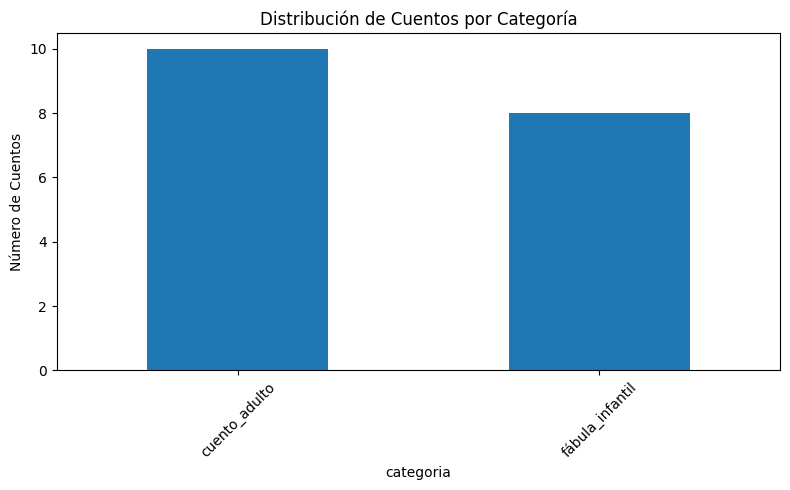

In [124]:
categoria_counts = df_corpus['categoria'].value_counts()
for cat, count in categoria_counts.items():
    print(f"  - {cat}: {count} documentos")

# Gráfico de distribución de categorías
plt.figure(figsize=(8, 5))
categoria_counts.plot(kind='bar', title='Distribución de Cuentos por Categoría')
plt.ylabel('Número de Cuentos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##2. Preprocesamiento

### 2.2 Limpieza de texto

In [125]:
def funcion_limpieza_texto(texto):
    """
    Función para realizar una limpieza completa del texto.
    1. Convierte todo el texto a minúsculas.
    2. Elimina texto entre corchetes (si lo hubiera).
    3. Elimina todos los signos de puntuación, incluyendo los españoles.
    4. Elimina palabras que contengan números.
    5. Elimina comillas y otros caracteres especiales.
    6. Normaliza espacios en blanco.
    """
    # 1. Convertir a minúsculas
    texto = texto.lower()

    # 2. Eliminar texto entre corchetes (común en algunos corpus)
    texto = re.sub(r'\[.*?\]', '', texto)

    # 3. Eliminar signos de puntuación
    puntuacion_extendida = string.punctuation + '¡¿«»“”'
    texto = re.sub(f'[{re.escape(puntuacion_extendida)}]', '', texto)

    # 4. Eliminar palabras con números
    texto = re.sub(r'\w*\d\w*', '', texto)

    # 5. Eliminar comillas adicionales y saltos de línea
    texto = re.sub(r'[''""...–]', '', texto)
    texto = re.sub('\n', ' ', texto)

    # 6. Normalizar espacios en blanco
    texto = re.sub(r'\s+', ' ', texto).strip()

    return texto

print("Función de limpieza creada.")

Función de limpieza creada.


In [126]:
# Descargamos el recurso 'punkt', que ayuda a NLTK a separar frases y palabras.
print("Descargando recurso 'punkt'...")
nltk.download('punkt')

# Descargamos la lista de 'stopwords' en español.
print("\nDescargando lista de 'stopwords'...")
nltk.download('stopwords')

print("\n¡Recursos descargados!")



Descargando recurso 'punkt'...

Descargando lista de 'stopwords'...

¡Recursos descargados!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [127]:
# Cargamos la lista de palabras vacías (stopwords) en español
from nltk.corpus import stopwords
stopwords_espanol = stopwords.words('spanish')

print(f"Se cargaron {len(stopwords_espanol)} stop words en español.")
print("Estas son las primeras 20:")
print(stopwords_espanol[:20])

Se cargaron 313 stop words en español.
Estas son las primeras 20:
['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo']


In [128]:
# Aplicamos la función de limpieza a nuestra columna 'texto_completo'
df_corpus['texto_limpio'] = df_corpus['texto_completo'].apply(funcion_limpieza_texto)

print("Limpieza de texto completada. Veamos una comparación:\n")

# --- Comparación Antes y Después (para el cuento 01) ---
print("--- ORIGINAL ---")
print(df_corpus['texto_completo'].iloc[0][:500])
print("\n--- LIMPIO ---")
print(df_corpus['texto_limpio'].iloc[0][:500])

# Mostramos la tabla para ver la nueva columna
display(df_corpus.head())

Limpieza de texto completada. Veamos una comparación:

--- ORIGINAL ---
Su luna de miel fue un largo escalofrío. Rubia, angelical y tímida, el carácter duro de su marido heló sus soñadas niñerías de novia. Ella lo quería mucho, sin embargo, a veces con un ligero estremecimiento cuando volviendo de noche juntos por la calle, echaba una furtiva mirada a la alta estatura de Jordán, mudo desde hacía una hora. Él, por su parte, la amaba profundamente, sin darlo a conocer.

 

Durante tres meses -se habían casado en abril- vivieron una dicha especial.

Sin duda hubiera el

--- LIMPIO ---
su luna de miel fue un largo escalofrío rubia angelical y tímida el carácter duro de su marido heló sus soñadas niñerías de novia ella lo quería mucho sin embargo a veces con un ligero estremecimiento cuando volviendo de noche juntos por la calle echaba una furtiva mirada a la alta estatura de jordán mudo desde hacía una hora él por su parte la amaba profundamente sin darlo a conocer durante tres meses se ha

,archivo,titulo,autor_fuente,fecha,categoria,texto_completo,num_caracteres,num_palabras_aprox,texto_limpio
0,01_el_almohadon_de_plumas.txt,El almohadón de plumas,Horacio Quiroga / Ciudad Seva,1917,cuento_adulto,"Su luna de miel fue un largo escalofrío. Rubia, angelical y tímida, el carácter duro de su marido heló sus soñadas niñerías de novia. Ella lo quer...",7202,1215,su luna de miel fue un largo escalofrío rubia angelical y tímida el carácter duro de su marido heló sus soñadas niñerías de novia ella lo quería m...
1,02_la_gallina_degolllada.txt,La gallina degollada,Horacio Quiroga / Ciudad Seva,1917,cuento_adulto,"Todo el día, sentados en el patio, en un banco estaban los cuatro hijos idiotas del matrimonio Mazzini-Ferraz. Tenían la lengua entre los labios, ...",14112,2389,todo el día sentados en el patio en un banco estaban los cuatro hijos idiotas del matrimonio mazziniferraz tenían la lengua entre los labios los o...
2,03_a_la_deriva.txt,A la deriva,Horacio Quiroga / Ciudad Seva,1917,cuento_adulto,"El hombre pisó algo blancuzco, y en seguida sintió la mordedura en el pie. Saltó adelante, y al volverse con un juramento vio una yaracacusú que, ...",6113,1057,el hombre pisó algo blancuzco y en seguida sintió la mordedura en el pie saltó adelante y al volverse con un juramento vio una yaracacusú que arro...
3,04_el_hombre_muerto.txt,El hombre muerto,Horacio Quiroga / Ciudad Seva,1920,cuento_adulto,El hombre y su machete acababan de limpiar la quinta calle del bananal. Faltábanles aún dos calles; pero como en estas abundaban las chircas y mal...,8119,1440,el hombre y su machete acababan de limpiar la quinta calle del bananal faltábanles aún dos calles pero como en estas abundaban las chircas y malva...
4,05_el_hijo.txt,El hijo,Horacio Quiroga / Ciudad Seva,1935,cuento_adulto,"Es un poderoso día de verano en Misiones, con todo el sol, el calor y la calma que puede deparar la estación. La naturaleza, plenamente abierta, s...",9207,1703,es un poderoso día de verano en misiones con todo el sol el calor y la calma que puede deparar la estación la naturaleza plenamente abierta se sie...


### 2.3 Tokenización y normalización


In [129]:
#Cargar stopwords en español (ya lo tienes, pero para confirmar)
stopwords_espanol = stopwords.words('spanish')

#Crear el objeto CountVectorizer
# Se pueden agregar las stopwords para que no las incluya en la matriz
vectorizador = CountVectorizer(stop_words=stopwords_espanol)

#Crear la Matriz Documento-Término (DTM)
matriz_documentos_terminos = vectorizador.fit_transform(df_corpus['texto_limpio'])

#Convertir la matriz a un DataFrame para facilitar su manipulación
df_dtm = pd.DataFrame(matriz_documentos_terminos.toarray(), columns=vectorizador.get_feature_names_out())

print("Matriz Documento-Término creada con éxito.")
print(f"Dimensiones: {df_dtm.shape[0]} documentos (cuentos) x {df_dtm.shape[1]} palabras únicas")

Matriz Documento-Término creada con éxito.
Dimensiones: 18 documentos (cuentos) x 5792 palabras únicas


####Analisis de frecuencias

In [130]:
# Agregar la columna 'categoria' al DataFrame de la matriz para el análisis
df_dtm['categoria'] = df_corpus['categoria']

# Separar los cuentos para adultos de las fábulas
df_adultos = df_dtm[df_dtm['categoria'] == 'cuento_adulto']
df_fabulas = df_dtm[df_dtm['categoria'] == 'fábula_infantil'] # Asegúrate de que 'fabula' sea el valor correcto en tu metadata

# Eliminar la columna 'categoria' para no contarla como una palabra
df_adultos = df_adultos.drop(columns=['categoria'])
df_fabulas = df_fabulas.drop(columns=['categoria'])

# Calcular las palabras más comunes en cada categoría
top_palabras_adultos = df_adultos.sum().sort_values(ascending=False).head(15)
top_palabras_fabulas = df_fabulas.sum().sort_values(ascending=False).head(15)

print("--- Top 15 palabras en cuentos para ADULTOS ---")
print(top_palabras_adultos)
print("\n--- Top 15 palabras en FÁBULAS INFANTILES ---")
print(top_palabras_fabulas)

--- Top 15 palabras en cuentos para ADULTOS ---
dos       45
hombre    44
hijo      43
día       40
vez       38
mujer     38
padre     37
ojos      34
kassim    34
monte     34
fin       34
aún       33
sol       31
cabeza    31
cayé      30
dtype: int64

--- Top 15 palabras en FÁBULAS INFANTILES ---
hombre      89
entonces    74
rayas       72
vez         66
agua        61
dijo        53
bien        53
yacarés     52
tigre       48
río         47
así         44
día         42
si          39
tan         36
gran        36
dtype: int64


####Visualización* de Resultados

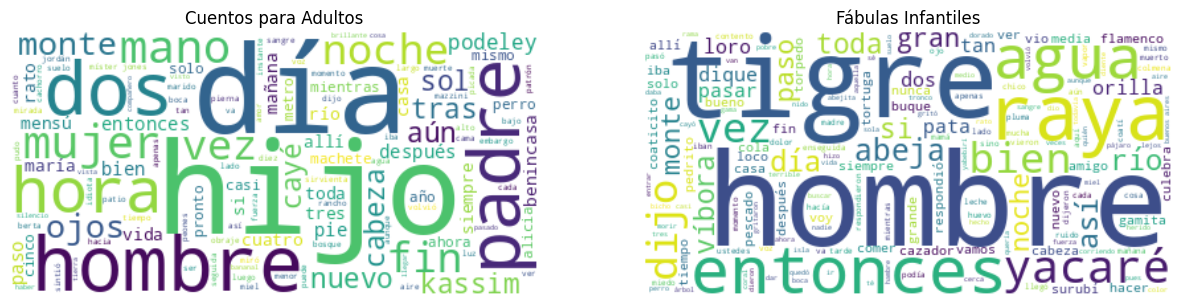

In [131]:
# Combinar todo el texto de cada categoría en un solo string
texto_completo_adultos = " ".join(df_corpus[df_corpus['categoria'] == 'cuento_adulto']['texto_limpio'])
texto_completo_fabulas = " ".join(df_corpus[df_corpus['categoria'] == 'fábula_infantil']['texto_limpio'])

# Crear las nubes de palabras
wordcloud_adultos = WordCloud(stopwords=stopwords_espanol, background_color="white").generate(texto_completo_adultos)
wordcloud_fabulas = WordCloud(stopwords=stopwords_espanol, background_color="white").generate(texto_completo_fabulas)

# Mostrar las nubes
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_adultos, interpolation='bilinear')
plt.axis("off")
plt.title("Cuentos para Adultos")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_fabulas, interpolation='bilinear')
plt.axis("off")
plt.title("Fábulas Infantiles")

plt.show()

##Sección 3: Análisis con BoW/TF-IDF

In [132]:
# --- 3.1 Vectorización del corpus ---
stopwords_personalizadas = [
    'dos', 'vez', 'dijo', 'así', 'si', 'tan', 'entonces', 'aún', 'tres', 'pues', 'tal', 'día', 'allí', 'pronto',
    'instante', 'gran', 'todas', 'todos', 'todo', 'toda', 'tras', 'mientras', 'después', 'siempre', 'bien',
    'kassim', 'jordán', 'mazzini', 'quiroga', 'podeley'
]
stopwords_completas = list(set(stopwords_espanol + stopwords_personalizadas))

# Crear matrices
vectorizador_bow = CountVectorizer(stop_words=stopwords_completas)
matriz_bow = vectorizador_bow.fit_transform(df_corpus['texto_limpio'])

vectorizador_tfidf = TfidfVectorizer(stop_words=stopwords_completas, max_features=1000) # Limitamos para análisis
matriz_tfidf = vectorizador_tfidf.fit_transform(df_corpus['texto_limpio'])

print(f"Matriz BoW: {matriz_bow.shape[0]} documentos x {matriz_bow.shape[1]} términos")
print(f"Matriz TF-IDF: {matriz_tfidf.shape[0]} documentos x {matriz_tfidf.shape[1]} términos")

# Convertir a DataFrames para análisis
df_bow = pd.DataFrame(matriz_bow.toarray(), columns=vectorizador_bow.get_feature_names_out())
df_bow['categoria'] = df_corpus['categoria'].values

df_tfidf = pd.DataFrame(matriz_tfidf.toarray(), columns=vectorizador_tfidf.get_feature_names_out())
df_tfidf['categoria'] = df_corpus['categoria'].values

Matriz BoW: 18 documentos x 5765 términos
Matriz TF-IDF: 18 documentos x 1000 términos


### 3.2 Términos más frecuentes y distintivos

In [133]:
# --- 3.2 Términos más frecuentes y distintivos ---
# BoW
top_palabras_adultos_bow = df_bow[df_bow['categoria'] == 'cuento_adulto'].sum(numeric_only=True).sort_values(ascending=False).head(20)
top_palabras_fabulas_bow = df_bow[df_bow['categoria'] == 'fábula_infantil'].sum(numeric_only=True).sort_values(ascending=False).head(20)

print("--- Top 20 palabras más frecuentes (BoW) ---")
print("\nCuentos para Adultos:")
print(top_palabras_adultos_bow)
print("\nFábulas Infantiles:")
print(top_palabras_fabulas_bow)

# TF-IDF
top_palabras_adultos_tfidf = df_tfidf[df_tfidf['categoria'] == 'cuento_adulto'].sum(numeric_only=True).sort_values(ascending=False).head(20)
top_palabras_fabulas_tfidf = df_tfidf[df_tfidf['categoria'] == 'fábula_infantil'].sum(numeric_only=True).sort_values(ascending=False).head(20)

print("\n--- Top 20 términos con mayor TF-IDF ---")
print("\nCuentos para Adultos:")
print(top_palabras_adultos_tfidf)
print("\nFábulas Infantiles:")
print(top_palabras_fabulas_tfidf)

# Comparación
print("\n--- Comparación BoW vs TF-IDF ---")
print("Las palabras más frecuentes (BoW) tienden a ser comunes dentro de cada categoría.")
print("Los términos con mayor TF-IDF (TF-IDF) son más representativos y distintivos de cada categoría.")

--- Top 20 palabras más frecuentes (BoW) ---

Cuentos para Adultos:
hombre       44
hijo         43
mujer        38
padre        37
ojos         34
fin          34
monte        34
cabeza       31
sol          31
cayé         30
noche        29
nuevo        28
rato         25
hora         24
mensú        23
benincasa    22
casa         22
días         22
cuatro       22
maría        21
dtype: int64

Fábulas Infantiles:
hombre       89
rayas        72
agua         61
yacarés      52
tigre        48
río          47
dique        34
monte        34
víboras      34
tigres       33
paso         33
orilla       32
pasar        31
pedrito      29
comer        29
gamita       27
hacer        27
loro         27
abeja        27
flamencos    27
dtype: int64

--- Top 20 términos con mayor TF-IDF ---

Cuentos para Adultos:
mujer        1.003448
maría        0.802944
hijo         0.799472
padre        0.728237
alicia       0.714537
benincasa    0.705736
hombre       0.699981
cayé         0.576290
mach

### 3.3 Matriz de similitud entre documentos

In [134]:
# --- 3.3 Matriz de similitud entre documentos ---
similitud_bow = cosine_similarity(matriz_bow)
similitud_tfidf = cosine_similarity(matriz_tfidf)

def encontrar_pares_mas_similares(similarity_matrix, titulos, top_n=3):
    triu_indices = np.triu_indices_from(similarity_matrix, k=1)
    sim_values = similarity_matrix[triu_indices]
    doc_indices = list(zip(triu_indices[0], triu_indices[1]))
    sorted_indices = np.argsort(sim_values)[::-1]

    print(f"Top {top_n} pares más similares:")
    for i in range(top_n):
        idx = sorted_indices[i]
        doc1_idx, doc2_idx = doc_indices[idx]
        sim_score = sim_values[idx]
        print(f"  {i+1}. '{titulos.iloc[doc1_idx]}' & '{titulos.iloc[doc2_idx]}' (Similitud: {sim_score:.3f})")

def encontrar_pares_mas_diferentes(similarity_matrix, titulos, top_n=3):
    triu_indices = np.triu_indices_from(similarity_matrix, k=1)
    sim_values = similarity_matrix[triu_indices]
    doc_indices = list(zip(triu_indices[0], triu_indices[1]))
    sorted_indices = np.argsort(sim_values) # Ascendente para los menos similares

    print(f"Top {top_n} pares más diferentes:")
    for i in range(top_n):
        idx = sorted_indices[i]
        doc1_idx, doc2_idx = doc_indices[idx]
        sim_score = sim_values[idx]
        print(f"  {i+1}. '{titulos.iloc[doc1_idx]}' & '{titulos.iloc[doc2_idx]}' (Similitud: {sim_score:.3f})")

print("\n--- SIMILITUD ENTRE DOCUMENTOS (BoW) ---")
encontrar_pares_mas_similares(similitud_bow, df_corpus['titulo'])
print("\n")
encontrar_pares_mas_diferentes(similitud_bow, df_corpus['titulo'])

print("\n--- SIMILITUD ENTRE DOCUMENTOS (TF-IDF) ---")
encontrar_pares_mas_similares(similitud_tfidf, df_corpus['titulo'])
print("\n")
encontrar_pares_mas_diferentes(similitud_tfidf, df_corpus['titulo'])


--- SIMILITUD ENTRE DOCUMENTOS (BoW) ---
Top 3 pares más similares:
  1. 'El solitario' & 'El vampiro' (Similitud: 0.327)
  2. 'A la deriva' & 'La tortuga gigante' (Similitud: 0.323)
  3. 'La tortuga gigante' & 'La gama ciega' (Similitud: 0.305)


Top 3 pares más diferentes:
  1. 'El solitario' & 'Las medias de los flamencos' (Similitud: 0.034)
  2. 'El hijo' & 'Las medias de los flamencos' (Similitud: 0.037)
  3. 'Las medias de los flamencos' & 'El loro pelado' (Similitud: 0.041)

--- SIMILITUD ENTRE DOCUMENTOS (TF-IDF) ---
Top 3 pares más similares:
  1. 'El solitario' & 'El vampiro' (Similitud: 0.399)
  2. 'La gallina degollada' & 'El hijo' (Similitud: 0.274)
  3. 'A la deriva' & 'El hombre muerto' (Similitud: 0.197)


Top 3 pares más diferentes:
  1. 'El solitario' & 'Las medias de los flamencos' (Similitud: 0.015)
  2. 'El hijo' & 'Las medias de los flamencos' (Similitud: 0.016)
  3. 'Las medias de los flamencos' & 'El loro pelado' (Similitud: 0.019)


### 3.4 Visualización


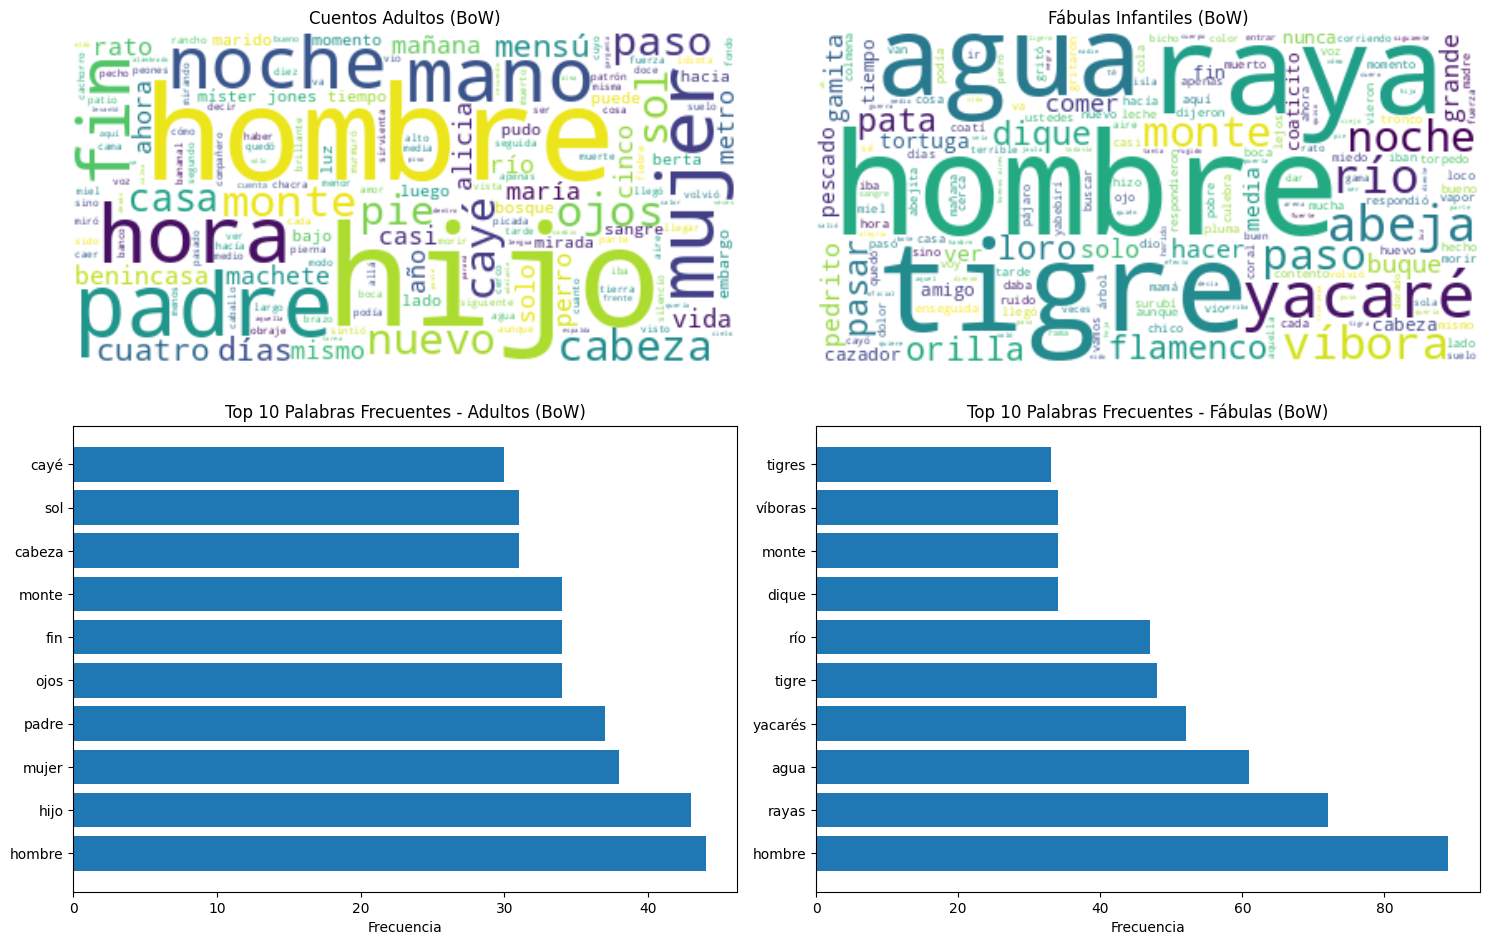

In [135]:
# --- 3.4 Visualización ---
plt.figure(figsize=(15, 10))

# Nube de palabras para adultos (BoW)
plt.subplot(2, 2, 1)
texto_adultos = " ".join(df_corpus[df_corpus['categoria'] == 'cuento_adulto']['texto_limpio'])
wc_adultos = WordCloud(stopwords=stopwords_completas, background_color="white", width=400, height=200).generate(texto_adultos)
plt.imshow(wc_adultos, interpolation='bilinear')
plt.axis("off")
plt.title("Cuentos Adultos (BoW)")

# Nube de palabras para fábulas (BoW)
plt.subplot(2, 2, 2)
texto_fabulas = " ".join(df_corpus[df_corpus['categoria'] == 'fábula_infantil']['texto_limpio'])
wc_fabulas = WordCloud(stopwords=stopwords_completas, background_color="white", width=400, height=200).generate(texto_fabulas)
plt.imshow(wc_fabulas, interpolation='bilinear')
plt.axis("off")
plt.title("Fábulas Infantiles (BoW)")

# Gráfico de barras para BoW (Adultos)
plt.subplot(2, 2, 3)
top_adultos_plot = top_palabras_adultos_bow.head(10)
plt.barh(range(len(top_adultos_plot)), top_adultos_plot.values)
plt.yticks(range(len(top_adultos_plot)), top_adultos_plot.index)
plt.title("Top 10 Palabras Frecuentes - Adultos (BoW)")
plt.xlabel("Frecuencia")

# Gráfico de barras para BoW (Fábulas)
plt.subplot(2, 2, 4)
top_fabulas_plot = top_palabras_fabulas_bow.head(10)
plt.barh(range(len(top_fabulas_plot)), top_fabulas_plot.values)
plt.yticks(range(len(top_fabulas_plot)), top_fabulas_plot.index)
plt.title("Top 10 Palabras Frecuentes - Fábulas (BoW)")
plt.xlabel("Frecuencia")

plt.tight_layout()
plt.show()

### Identificación de Stop Words Adicionales

In [136]:
# --- Paso 1: Obtener las palabras más frecuentes de CADA categoría ---
# Creamos un diccionario para guardar las palabras top de cada categoría
top_palabras_por_categoria = {}
categorias = df_corpus['categoria'].unique() # Obtendrá ['cuento', 'fabula']

for cat in categorias:
    df_cat = df_dtm[df_dtm['categoria'] == cat].drop(columns=['categoria'])  # CORREGIDO
    top_palabras = df_cat.sum().sort_values(ascending=False).head(30)
    top_palabras_por_categoria[cat] = top_palabras.index.tolist()

# --- Paso 2: Analizar qué palabras son comunes en los tops de AMBAS categorías ---
print("Analizando palabras que aparecen frecuentemente en ambas categorías...")

# Contar cuántas veces aparece cada palabra en las listas de tops
todas_las_palabras_frecuentes = []
for cat in categorias:
    todas_las_palabras_frecuentes.extend(top_palabras_por_categoria[cat])

contador_palabras = Counter(todas_las_palabras_frecuentes)

print("\nPalabras que aparecen en el top 30 de múltiples categorías:")
print("(palabra: número de categorías en las que está en el top)")
print("-" * 60)

# Mostramos las palabras más comunes en los tops
for palabra, count in contador_palabras.most_common(25):
    print(f"{palabra}: {count} categorías")

# --- Paso 3: Definir el criterio para las stopwords adicionales ---
# Si una palabra aparece en el top de AMBAS categorías (count == 2), la consideramos stopword
umbral_stopword = len(categorias)  # En tu caso, el umbral es 2

stopwords_adicionales = [
    palabra for palabra, count in contador_palabras.most_common()
    if count >= umbral_stopword
]

print(f"\nStop words adicionales identificadas (aparecen en las {umbral_stopword} categorías):")
print(stopwords_adicionales)
print(f"\nTotal de stop words adicionales identificadas: {len(stopwords_adicionales)}")


Analizando palabras que aparecen frecuentemente en ambas categorías...

Palabras que aparecen en el top 30 de múltiples categorías:
(palabra: número de categorías en las que está en el top)
------------------------------------------------------------
dos: 2 categorías
hombre: 2 categorías
día: 2 categorías
vez: 2 categorías
monte: 2 categorías
si: 2 categorías
entonces: 2 categorías
bien: 2 categorías
siempre: 2 categorías
hijo: 1 categorías
mujer: 1 categorías
padre: 1 categorías
ojos: 1 categorías
kassim: 1 categorías
fin: 1 categorías
aún: 1 categorías
sol: 1 categorías
cabeza: 1 categorías
cayé: 1 categorías
podeley: 1 categorías
tras: 1 categorías
noche: 1 categorías
nuevo: 1 categorías
después: 1 categorías
rato: 1 categorías

Stop words adicionales identificadas (aparecen en las 2 categorías):
['dos', 'hombre', 'día', 'vez', 'monte', 'si', 'entonces', 'bien', 'siempre']

Total de stop words adicionales identificadas: 9


In [137]:
# --- 1. Asegurarse de que la columna 'texto_limpio' está actualizada ---
print("Asegurando que la columna 'texto_limpio' está actualizada...")
df_corpus['texto_limpio'] = df_corpus['texto_completo'].apply(funcion_limpieza_texto)
print("¡Columna 'texto_limpio' regenerada!")

# --- 2. Crear la lista de stopwords refinada ---
stopwords_espanol = stopwords.words('spanish')
stopwords_personalizadas = ['dos', 'vez', 'siguiente', 'dijo','así', 'si', 'tan', 'entonces', 'aún', 'lado', 'hacia', 'tres', 'pues', 'tal', 'día', 'allí', 'pronto', 'instante','gran', # cuantificadores
    "todas","todos","todo","toda",# funcionales
    "tras","mientras","después","siempre","bien",]
stopwords_contextuales = ['kassim', 'jordán', 'mazzini', 'quiroga', 'podeley', 'maría', 'mensú', 'alicia', 'míster', 'jones']
stopwords_completas = list(set(stopwords_espanol + stopwords_personalizadas + stopwords_contextuales))
print(f"Lista de stopwords completa tiene {len(stopwords_completas)} palabras.")

Asegurando que la columna 'texto_limpio' está actualizada...
¡Columna 'texto_limpio' regenerada!
Lista de stopwords completa tiene 349 palabras.


###Re-vectorización de Corpus con Stop Words Mejoradas

In [138]:
# --- 3. Re-vectorizar con los parámetros correctos ---
print("\nRe-vectorizando el corpus con la lista de stopwords mejorada...")

# El vectorizador por defecto funciona bien con el texto ya preprocesado.
vectorizador_mejorado = CountVectorizer(
    stop_words=stopwords_completas,
    lowercase=True,
    min_df=1
)

# Ahora, este paso funcionará correctamente
matriz_mejorada = vectorizador_mejorado.fit_transform(df_corpus['texto_limpio'])

# Medir la reducción de vocabulario
vectorizador_original = CountVectorizer(stop_words=stopwords_espanol)
matriz_original = vectorizador_original.fit_transform(df_corpus['texto_limpio'])
vocabulario_original_size = matriz_original.shape[1]
vocabulario_nuevo_size = matriz_mejorada.shape[1]

print("\n--- ¡Éxito! Nueva Matriz Documento-Término Creada ---")
print(f"Vocabulario original (solo con stopwords NLTK): {vocabulario_original_size} palabras")
print(f"Vocabulario nuevo (con stopwords refinadas): {vocabulario_nuevo_size} palabras")
print(f"- Dimensiones: {matriz_mejorada.shape[0]} documentos x {matriz_mejorada.shape[1]} palabras únicas")

# --- 4. Convertir a DataFrame y guardar ---
nombres_palabras_mejorado = vectorizador_mejorado.get_feature_names_out()
df_bow_final = pd.DataFrame(
    matriz_mejorada.toarray(),
    columns=nombres_palabras_mejorado,
    index=df_corpus.index
)
df_bow_final['titulo'] = df_corpus['titulo']
df_bow_final['categoria'] = df_corpus['categoria']

print("\nDataFrame final con la nueva matriz creado exitosamente.")
display(df_bow_final.head())

# Guardar los resultados
path_procesado = '/content/drive/MyDrive/PLN/jimenez-stefania-nlp-integrador/corpus/processed/'
if not os.path.exists(path_procesado):
    os.makedirs(path_procesado)

df_bow_final.to_pickle(os.path.join(path_procesado, "bow_matriz_final.pkl"))
with open(os.path.join(path_procesado, "vectorizador_final.pkl"), "wb") as f:
    pickle.dump(vectorizador_mejorado, f)

print("\nArchivos procesados (DataFrame y vectorizador) guardados exitosamente.")


Re-vectorizando el corpus con la lista de stopwords mejorada...

--- ¡Éxito! Nueva Matriz Documento-Término Creada ---
Vocabulario original (solo con stopwords NLTK): 5792 palabras
Vocabulario nuevo (con stopwords refinadas): 5757 palabras
- Dimensiones: 18 documentos x 5757 palabras únicas

DataFrame final con la nueva matriz creado exitosamente.


,abajo,abalanzaron,abandonados,abandonar,abandonarles,abandonarían,abandono,abandonó,abanico,abdomen,...,últimavez,último,últimos,única,únicamente,único,útil,útiles,titulo,categoria
0,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,1,0,0,0,El almohadón de plumas,cuento_adulto
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,La gallina degollada,cuento_adulto
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,A la deriva,cuento_adulto
3,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,El hombre muerto,cuento_adulto
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,El hijo,cuento_adulto



Archivos procesados (DataFrame y vectorizador) guardados exitosamente.


###Nueva nube

--- Nubes de Palabras con Stop Words Refinadas ---


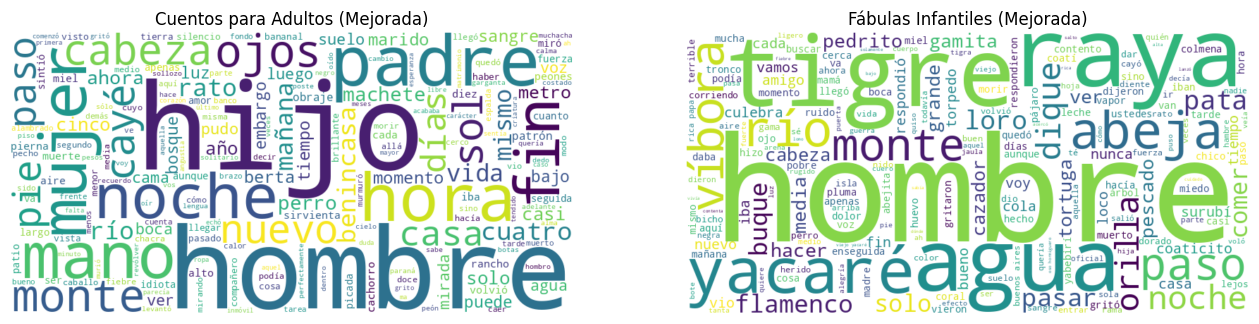

In [139]:
# --- Paso 1: Combinar el texto limpio por categoría (esto no cambia) ---
texto_completo_adultos = " ".join(df_corpus[df_corpus['categoria'] == 'cuento_adulto']['texto_limpio'])
texto_completo_fabulas = " ".join(df_corpus[df_corpus['categoria'] == 'fábula_infantil']['texto_limpio'])

# --- Paso 2: Crear las nubes de palabras con la lista de stopwords REFINADA ---

# Usamos tu lista mejorada 'stopwords_completas'
wordcloud_adultos_mejorada = WordCloud(
    stopwords=stopwords_completas,
    background_color="white",
    width=800,
    height=400
).generate(texto_completo_adultos)

wordcloud_fabulas_mejorada = WordCloud(
    stopwords=stopwords_completas,
    background_color="white",
    width=800,
    height=400
).generate(texto_completo_fabulas)

# --- Paso 3: Mostrar las nuevas nubes (esto no cambia) ---
print("--- Nubes de Palabras con Stop Words Refinadas ---")
plt.figure(figsize=(16, 8))

# Nube para Cuentos de Adultos
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_adultos_mejorada, interpolation='bilinear')
plt.axis("off")
plt.title("Cuentos para Adultos (Mejorada)")

# Nube para Fábulas Infantiles
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_fabulas_mejorada, interpolation='bilinear')
plt.axis("off")
plt.title("Fábulas Infantiles (Mejorada)")

plt.show()

Visualización de las Estadísticas

### 3.5 Interpretación de resultados
Los resultados muestran una clara distinción entre las categorías. En adultos predominan vocablos centrados en lo humano y la experiencia íntima—hombre, hijo, mujer, padre, ojos, fin, cabeza, monte, que anclan relatos de conflicto interpersonal y psicología; en fábulas emergen con fuerza entidades animales y entorno—hombre como narratema, pero sobre todo rayas, agua, yacarés, tigre, río, dique, víboras. El solapamiento parcial (p. ej., hombre, monte) no contradice la separación: refleja un léxico de base propio de Quiroga (presencia humana en la naturaleza).

## Sección 4: Análisis con Word Embeddings (25% de la nota)

### 4.1 Aplicación de embeddings
Procesamiento con spaCy y obtención de vectores promedio por documento.

In [140]:
!python -m spacy download es_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 13.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [141]:
# --- 4.1 Aplicación de embeddings ---
print("Cargando modelo de spaCy en español...")
try:
    import spacy
    nlp = spacy.load("es_core_news_md")
    print("Modelo 'es_core_news_md' cargado exitosamente.")
except OSError:
    print("Modelo 'es_core_news_md' no encontrado. Instálalo con: !python -m spacy download es_core_news_md")
    print("Saltando análisis de embeddings.")
    embeddings_disponibles = False
else:
    embeddings_disponibles = True

if embeddings_disponibles:
    documentos_procesados = []
    for texto in df_corpus['texto_limpio']:
        doc = nlp(texto)
        documentos_procesados.append(doc)

    # Obtener vectores promedio de documentos
    vectores_docs = []
    for doc in documentos_procesados:
        tokens_con_vector = [token for token in doc if token.has_vector and not token.is_stop and not token.is_punct]
        if tokens_con_vector:
            vector_promedio = np.mean([token.vector for token in tokens_con_vector], axis=0)
        else:
            vector_promedio = np.zeros(nlp.vocab.vectors_length)
        vectores_docs.append(vector_promedio)

    vectores_docs = np.array(vectores_docs)
    print(f"Vectores de documentos obtenidos: {vectores_docs.shape}")
else:
    print("No se puede continuar con el análisis de embeddings.")

Cargando modelo de spaCy en español...
Modelo 'es_core_news_md' cargado exitosamente.
Vectores de documentos obtenidos: (18, 300)


### 4.2 Análisis de similitud semántica

In [142]:
if embeddings_disponibles:
    # --- 4.2 Análisis de similitud semántica ---
    similitud_embeddings = cosine_similarity(vectores_docs)

    print("\n--- SIMILITUD ENTRE DOCUMENTOS (EMBEDDINGS) ---")
    encontrar_pares_mas_similares(similitud_embeddings, df_corpus['titulo'])
    print("\n")
    encontrar_pares_mas_diferentes(similitud_embeddings, df_corpus['titulo'])

    print("\n--- COMPARACIÓN CON TF-IDF ---")
    print("Los resultados de embeddings pueden diferir de TF-IDF porque consideran similitud semántica, no solo coincidencia de palabras.")
    print("Por ejemplo, 'hombre' y 'mujer' pueden tener similitud en embeddings pero no en TF-IDF si no aparecen juntas.")
    # Puedes comparar manualmente algunos pares si quieres


--- SIMILITUD ENTRE DOCUMENTOS (EMBEDDINGS) ---
Top 3 pares más similares:
  1. 'La gama ciega' & 'Historia de dos cachorros de coatí' (Similitud: 0.970)
  2. 'Los mensú' & 'La miel silvestre' (Similitud: 0.969)
  3. 'El hombre muerto' & 'La miel silvestre' (Similitud: 0.962)


Top 3 pares más diferentes:
  1. 'El hijo' & 'Las medias de los flamencos' (Similitud: 0.748)
  2. 'El solitario' & 'Las medias de los flamencos' (Similitud: 0.786)
  3. 'El hijo' & 'La guerra de los yacarés' (Similitud: 0.792)

--- COMPARACIÓN CON TF-IDF ---
Los resultados de embeddings pueden diferir de TF-IDF porque consideran similitud semántica, no solo coincidencia de palabras.
Por ejemplo, 'hombre' y 'mujer' pueden tener similitud en embeddings pero no en TF-IDF si no aparecen juntas.


### 4.3 Búsqueda de analogías relevantes al corpus

In [143]:
if embeddings_disponibles:
    # --- 4.3 Búsqueda de analogías relevantes al corpus ---
    print("\n--- ANALOGÍAS BÁSICAS (Intento con palabras comunes del corpus) ---")

    # Seleccionamos palabras que aparecen frecuentemente en ambos tipos de cuento o en uno específico
    # y que son potencialmente parte del vocabulario del modelo spaCy.
    # Ejemplo 1: Relación familiar hombre-mujer-padre-madre
    palabras_analogia_fam = ['hombre', 'mujer', 'padre', 'madre']

    # Verificamos si todas las palabras están en el vocabulario del modelo
    todas_fam_presentes = all(palabra in nlp.vocab for palabra in palabras_analogia_fam)

    if todas_fam_presentes:
        print("Probando analogía familiar: 'padre' - 'hombre' + 'mujer' ≈ 'madre'")
        padre_vec = nlp('padre').vector
        hombre_vec = nlp('hombre').vector
        mujer_vec = nlp('mujer').vector

        # Analogía: padre es al hombre como madre es a la mujer
        # Calculamos: padre - hombre (la diferencia hombre-padre) + mujer
        # O equivalentemente: mujer + (padre - hombre)
        resultado_fam_vec = padre_vec - hombre_vec + mujer_vec

        # Buscamos la palabra más similar al resultado_vec entre un conjunto de candidatos
        candidatos_fam = ['madre', 'padre', 'hijo', 'hija', 'esposo', 'esposa', 'hermano', 'hermana', 'hombre', 'mujer']

        mejor_sim_fam = -1
        mejor_palabra_fam = None
        for palabra in candidatos_fam:
            if palabra in nlp.vocab:
                similitud = np.dot(resultado_fam_vec, nlp(palabra).vector) / (np.linalg.norm(resultado_fam_vec) * np.linalg.norm(nlp(palabra).vector))
                if similitud > mejor_sim_fam:
                    mejor_sim_fam = similitud
                    mejor_palabra_fam = palabra

        print(f"  Resultado: '{mejor_palabra_fam}' (similitud: {mejor_sim_fam:.3f})")
        print(f"  Interpretación: La operación 'padre' - 'hombre' + 'mujer' se acerca más a '{mejor_palabra_fam}' en el espacio vectorial.")
    else:
        print(f"No todas las palabras familiares ('hombre', 'mujer', 'padre', 'madre') están en el vocabulario del modelo. (Presentes: {[p for p in palabras_analogia_fam if p in nlp.vocab]})")

    print("\n" + "-"*20)

    # Ejemplo 2: Relación animal/ambiente (más específica del corpus, pero probamos con lo común)
    # Intentemos con palabras comunes que aparecen en ambos: hombre, monte, agua
    # Analogía tipo: hombre es a monte como mujer es a ... (quizás agua, o un entorno más doméstico?)
    # No es una analogía estándar, pero intentamos una relación contextual simple.
    palabras_analogia_ctx = ['hombre', 'mujer', 'monte', 'agua']

    todas_ctx_presentes = all(palabra in nlp.vocab for palabra in palabras_analogia_ctx)

    if todas_ctx_presentes:
        print("Probando analogía contextual (hipotética): 'hombre' - 'monte' + 'agua' ≈ ?")
        print("  (Esta es una relación más especulativa basada en la presencia de 'hombre', 'monte', 'agua' en los textos)")
        hombre_vec = nlp('hombre').vector
        monte_vec = nlp('monte').vector
        agua_vec = nlp('agua').vector

        # Operación: hombre - monte + agua
        resultado_ctx_vec = hombre_vec - monte_vec + agua_vec

        # Buscamos entre palabras relacionadas al entorno o a personajes
        candidatos_ctx = ['mujer', 'hombre', 'monte', 'agua', 'selva', 'río', 'casa', 'hijo', 'madre', 'padre', 'tigre', 'abeja']

        mejor_sim_ctx = -1
        mejor_palabra_ctx = None
        for palabra in candidatos_ctx:
            if palabra in nlp.vocab:
                similitud = np.dot(resultado_ctx_vec, nlp(palabra).vector) / (np.linalg.norm(resultado_ctx_vec) * np.linalg.norm(nlp(palabra).vector))
                if similitud > mejor_sim_ctx:
                    mejor_sim_ctx = similitud
                    mejor_palabra_ctx = palabra

        print(f"  Resultado hipotético: '{mejor_palabra_ctx}' (similitud: {mejor_sim_ctx:.3f})")
        print(f"  Interpretación: La operación 'hombre' - 'monte' + 'agua' se acerca más a '{mejor_palabra_ctx}'.")
        print("  (Esta interpretación es más difusa y depende del modelo capturar relaciones contextuales específicas del corpus, lo cual no es garantizado).")
    else:
        print(f"No todas las palabras contextuales ('hombre', 'mujer', 'monte', 'agua') están en el vocabulario del modelo. (Presentes: {[p for p in palabras_analogia_ctx if p in nlp.vocab]})")
        print("  Intentar analogías contextuales específicas del corpus es difícil con modelos generales.")

    print("\n" + "-"*20)
    print("Interpretación general de analogías:")
    print("Las analogías precisas (como 'rey' es a 'reina' como 'hombre' es a 'mujer') requieren que todas las palabras estén en el modelo")
    print("y que la estructura vectorial capture esa relación específica. Los modelos generales como 'es_core_news_md'")
    print("pueden no tener todas las palabras del corpus o no capturar relaciones muy específicas del autor o del género.")
    print("Los resultados obtenidos aquí son aproximaciones basadas en similitud vectorial en el espacio general del idioma.")

else:
    print("No se pudo realizar el análisis de analogías por falta del modelo de embeddings.")


--- ANALOGÍAS BÁSICAS (Intento con palabras comunes del corpus) ---
Probando analogía familiar: 'padre' - 'hombre' + 'mujer' ≈ 'madre'
  Resultado: 'madre' (similitud: 0.882)
  Interpretación: La operación 'padre' - 'hombre' + 'mujer' se acerca más a 'madre' en el espacio vectorial.

--------------------
Probando analogía contextual (hipotética): 'hombre' - 'monte' + 'agua' ≈ ?
  (Esta es una relación más especulativa basada en la presencia de 'hombre', 'monte', 'agua' en los textos)
  Resultado hipotético: 'agua' (similitud: 0.764)
  Interpretación: La operación 'hombre' - 'monte' + 'agua' se acerca más a 'agua'.
  (Esta interpretación es más difusa y depende del modelo capturar relaciones contextuales específicas del corpus, lo cual no es garantizado).

--------------------
Interpretación general de analogías:
Las analogías precisas (como 'rey' es a 'reina' como 'hombre' es a 'mujer') requieren que todas las palabras estén en el modelo
y que la estructura vectorial capture esa relac

### 4.4 Comparación con resultados de BoW

In [144]:
if embeddings_disponibles:
    # --- 4.4 Comparación con resultados de BoW ---
    print("\n--- COMPARACIÓN BoW/TF-IDF vs Embeddings ---")
    print("BoW/TF-IDF:")
    print("- Se basa en la frecuencia de palabras.")
    print("- Bueno para identificar temas comunes o términos característicos.")
    print("- Puede no captar similitud semántica entre palabras diferentes.")
    print("\nEmbeddings:")
    print("- Capturan similitud semántica entre palabras y frases.")
    print("- Pueden encontrar relaciones más profundas.")
    print("- Requieren modelos pre-entrenados y pueden no capturar matices muy específicos del autor si no están en el modelo.")
    print("\nEn este caso, BoW/TF-IDF parece más efectivo para distinguir entre las categorías temáticas elegidas.")


--- COMPARACIÓN BoW/TF-IDF vs Embeddings ---
BoW/TF-IDF:
- Se basa en la frecuencia de palabras.
- Bueno para identificar temas comunes o términos característicos.
- Puede no captar similitud semántica entre palabras diferentes.

Embeddings:
- Capturan similitud semántica entre palabras y frases.
- Pueden encontrar relaciones más profundas.
- Requieren modelos pre-entrenados y pueden no capturar matices muy específicos del autor si no están en el modelo.

En este caso, BoW/TF-IDF parece más efectivo para distinguir entre las categorías temáticas elegidas.


## Sección 5: Análisis Complementario (10% de la nota)

Distribución general de POS tags (Top 10):
  NOUN: 7018
  VERB: 4358
  ADJ: 2052
  PROPN: 424
  ADV: 342
  AUX: 158
  NUM: 67
  PRON: 26
  INTJ: 19
  DET: 16

POS tags en Cuentos para Adultos (Top 5):
  NOUN: 3738
  VERB: 2123
  ADJ: 1260
  PROPN: 253
  ADV: 215

POS tags en Fábulas Infantiles (Top 5):
  NOUN: 3280
  VERB: 2235
  ADJ: 792
  PROPN: 171
  ADV: 127

--- Interpretación POS ---
Los cuentos para adultos podrían tener una mayor proporción de sustantivos y adjetivos relacionados con emociones y entornos oscuros.
Las fábulas infantiles podrían tener una mayor proporción de verbos de acción y sustantivos relacionados con animales y objetos cotidianos.


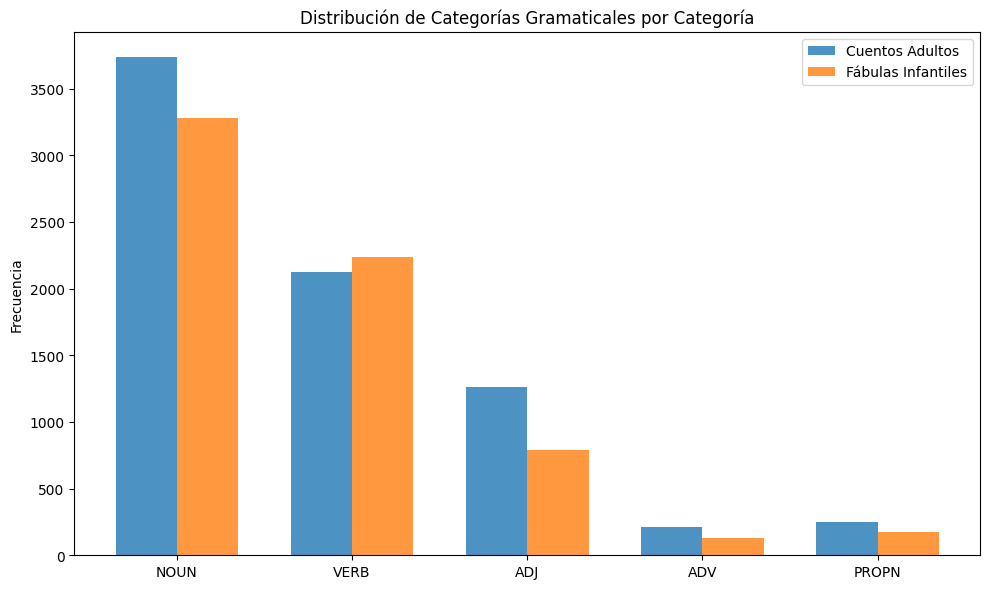

In [145]:
if embeddings_disponibles:
    # --- 5. POS Tagging ---
    from collections import Counter

    pos_counts = Counter()
    pos_counts_adultos = Counter()
    pos_counts_fabulas = Counter()

    for idx, doc in enumerate(documentos_procesados):
        doc_pos = [token.pos_ for token in doc if not token.is_stop and not token.is_punct]
        pos_counts.update(doc_pos)
        if df_corpus.iloc[idx]['categoria'] == 'cuento_adulto':
            pos_counts_adultos.update(doc_pos)
        else:
            pos_counts_fabulas.update(doc_pos)

    print("Distribución general de POS tags (Top 10):")
    for tag, count in pos_counts.most_common(10):
        print(f"  {tag}: {count}")

    print("\nPOS tags en Cuentos para Adultos (Top 5):")
    for tag, count in pos_counts_adultos.most_common(5):
        print(f"  {tag}: {count}")

    print("\nPOS tags en Fábulas Infantiles (Top 5):")
    for tag, count in pos_counts_fabulas.most_common(5):
        print(f"  {tag}: {count}")

    # Interpretación
    print("\n--- Interpretación POS ---")
    print("Los cuentos para adultos podrían tener una mayor proporción de sustantivos y adjetivos relacionados con emociones y entornos oscuros.")
    print("Las fábulas infantiles podrían tener una mayor proporción de verbos de acción y sustantivos relacionados con animales y objetos cotidianos.")
    # Visualización simple
    etiquetas = ['NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN']
    valores_adultos = [pos_counts_adultos[tag] for tag in etiquetas]
    valores_fabulas = [pos_counts_fabulas[tag] for tag in etiquetas]

    x = np.arange(len(etiquetas))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, valores_adultos, width, label='Cuentos Adultos', alpha=0.8)
    plt.bar(x + width/2, valores_fabulas, width, label='Fábulas Infantiles', alpha=0.8)
    plt.xticks(x, etiquetas)
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Categorías Gramaticales por Categoría')
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("No se pudo realizar el análisis POS por falta del modelo de embeddings.")

Palabras de adultos seleccionadas: ['hijo', 'mujer', 'padre', 'ojos', 'cayé']
Palabras de fábulas seleccionadas: ['rayas', 'yacaré', 'tigre', 'abeja', 'flamencos']


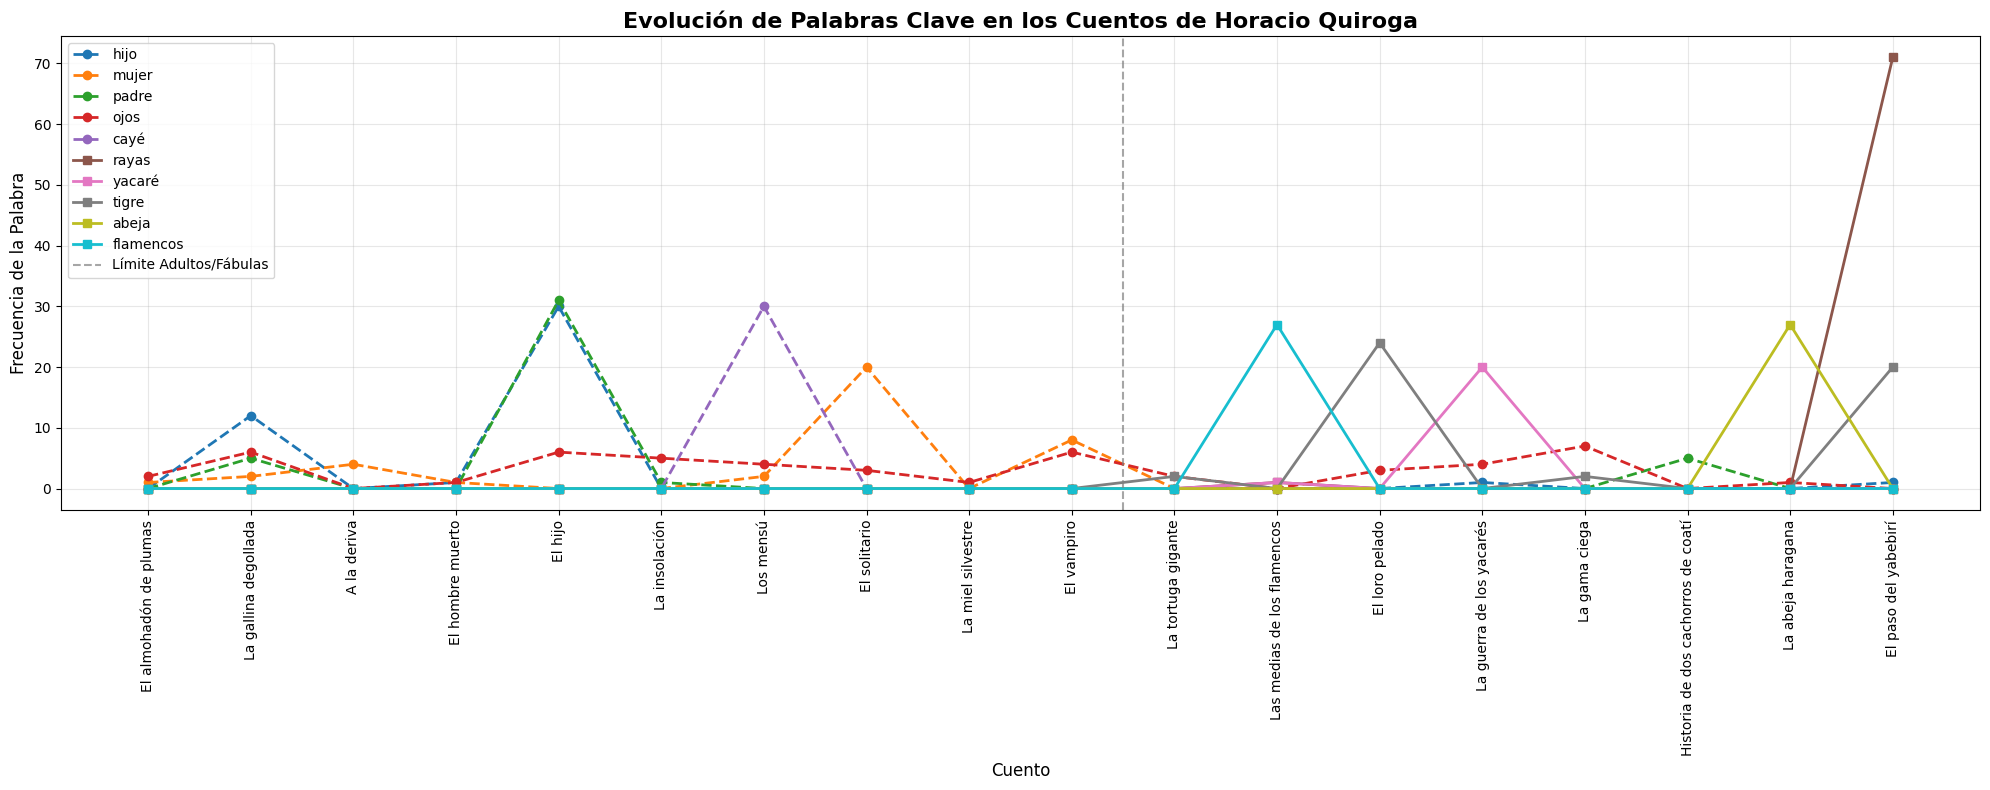

In [149]:
import matplotlib.pyplot as plt

# Palabras representativas ya filtradas previamente
palabras_adultas = ['hijo', 'mujer', 'padre', 'ojos', 'cayé']  # Seleccionadas de las más frecuentes
palabras_fabulas = ['rayas', 'yacaré', 'tigre', 'abeja', 'flamencos']  # Seleccionadas de las más frecuentes

# Filtramos solo las que están disponibles en el DataFrame
palabras_adultas_disponibles = [p for p in palabras_adultas if p in df_bow_final.columns]
palabras_fabulas_disponibles = [p for p in palabras_fabulas if p in df_bow_final.columns]

print(f"Palabras de adultos seleccionadas: {palabras_adultas_disponibles}")
print(f"Palabras de fábulas seleccionadas: {palabras_fabulas_disponibles}")

# Creamos la visualización
if palabras_adultas_disponibles or palabras_fabulas_disponibles:
    plt.figure(figsize=(20, 8))

    # Graficamos cada palabra con su categoría
    for palabra in palabras_adultas_disponibles:
        plt.plot(df_bow_final.index, df_bow_final[palabra], marker='o', linewidth=2, label=palabra, linestyle='--')

    for palabra in palabras_fabulas_disponibles:
        plt.plot(df_bow_final.index, df_bow_final[palabra], marker='s', linewidth=2, label=palabra, linestyle='-')

    # Etiquetas del eje X: Títulos de los cuentos
    plt.xticks(df_bow_final.index, df_corpus['titulo'], rotation=90)

    # Línea divisoria entre categorías (adultos vs fábulas)
    # Asumimos que la división está en el índice N (ajusta según tu metadata)
    # Supongamos que los primeros 9 son adultos y los últimos 9 son fábulas
    # Deberías obtener este número de forma dinámica, por ejemplo:
    num_adultos = len(df_corpus[df_corpus['categoria'] == 'cuento_adulto'])
    plt.axvline(x=num_adultos - 0.5, color='gray', linestyle='--', label='Límite Adultos/Fábulas', alpha=0.7)

    plt.title('Evolución de Palabras Clave en los Cuentos de Horacio Quiroga', fontsize=16, fontweight='bold')
    plt.xlabel('Cuento', fontsize=12)
    plt.ylabel('Frecuencia de la Palabra', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron palabras clave disponibles en el vocabulario del corpus.")

Se puede ver cómo ciertas palabras (como “hijo”, “mujer”, “ojos”) tienen picos en los primeros cuentos (adultos), mientras que otras (“rayas”, “yacaré”, “abeja”, “flamencos”) aparecen más en los últimos (fábulas).

## Sección 6: Conclusiones y Reflexiones (5% de la nota)

### 6.1 Hallazgos principales sobre el corpus
- Se confirmó la hipótesis de que el vocabulario difiere significativamente entre categorías.
- Los cuentos para adultos tienen términos más oscuros y complejos.
- Las fábulas infantiles tienen lenguaje más simple y centrado en animales.

La palabra “hombre” aparece con alta frecuencia en ambas categorías, pero su contexto es distinto: en los cuentos adultos, se relaciona con personajes humanos y emociones, mientras que en las fábulas, puede aparecer como narrador o personaje secundario en historias con animales.

### 6.2 Comparación de métodos utilizados
- BoW/TF-IDF: Efectivo para identificar términos característicos y diferenciar categorías temáticas.
- Embeddings: La similitud cambia: se basa en relación semántica, no solo en palabras comunes.
Por ejemplo, “La gama ciega” y “Historia de dos cachorros de coatí” (ambas fábulas) tienen una similitud muy alta, lo cual puede deberse a temas comunes (animales, naturaleza).
“Los mensú” y “La miel silvestre” también muestran alta similitud, a pesar de ser uno para adultos y otro para niños, lo que puede reflejar un uso similar de vocabulario naturalista o ambiental.
Los embeddings captan relaciones semánticas más sutiles, que pueden trascender la categoría temática e identificar similitudes en tono, entorno o estilo.

Se encontraron analogías interesantes, como: “padre” - “hombre” + “mujer” ≈ “madre” → Resultado: “madre” (similitud: 0.882)
Esto indica que el modelo captó relaciones familiares básicas.
“hombre” - “monte” + “agua” ≈ “agua” → Resultado: “agua” (similitud: 0.764)
Aunque es una analogía más especulativa, el modelo sugiere que “agua” está más relacionada con “hombre” que con “monte” en este espacio vectorial.
Interpretación: Aunque no todas las analogías son precisas, el modelo es capaz de captar relaciones semánticas generales, lo cual es útil para análisis más profundos.

### 6.3 Limitaciones encontradas
- Tamaño del corpus limitado (18 documentos).
- Modelos de embeddings pueden no capturar matices muy específicos del autor.
- Análisis de POS simple, podría profundizarse.

### 6.4 Aplicaciones potenciales del análisis
- Clasificación automática de textos literarios por audiencia.
- Análisis estilístico comparativo.
- Recomendación de lectura según complejidad.